# Figure 1

The code below has been used to create Figure 1c and 1d in [the main paper](https://www.biorxiv.org/content/10.1101/2022.03.18.484903v2) as well as Figures S37-S43 and S46 in the [supplement](https://www.biorxiv.org/content/10.1101/2022.03.18.484903v2.supplementary-material).

Contact: pawel.szczerbiak@uj.edu.pl or p.szczerbiak@gmail.com

## Setting environment

Before running other cells, run the commands below in the terminal and activate the  `<env_name>` kernel in this notebook:

`conda create -n <env_name> -c bioconda -c conda-forge emperor umap-learn numpy ipykernel`  
`conda activate <env_name>`  
`ipython kernel install --user --name=<env_name>`

Alternatively, one can use `virtualenv` instead of `conda` package manager.

In [1]:
import pickle
import umap
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from emperor import Emperor, nbinstall, scatterplot
from mpl_toolkits.axes_grid1 import ImageGrid

/home/MCB/pszczerbiak/miniconda3/envs/emperor/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Global paths

**NOTE:** change the paths below appropriately.  
The first one should point to the `intermediate_data` folder downloded from the [Zenodo](https://zenodo.org/record/6477242#.Yoyp1PNBxqs) website.

In [2]:
MAIN_DIR = Path('/path/to/intermediate_data/')
OUT_DIR = Path('./')  # current notebook directory

## Embeddings generation

In order to generate data stored in `embeddings` folder we need to perform the following steps (to be done for all structures in `MIP_visualization` dataset):

- First, we generate a contact map (`pt` file) from a `pdb` file e.g. using [this](https://github.com/djberenberg/characterizing-gcns/blob/master/mkdmap.py) script:

`python mkdmap.py pdb_dir/input.pdb input.pt`

- Second, we construct embedding as normalized graphlet counts using [this](https://github.com/djberenberg/graphletcounts) Github repository:

`python count_graphlets.py -mode grafene -t 6 input.pt input.npz`

- All embeddings (from specific group ie. `rosetta`, `dmpfold`, `cath`) may be then merged into a single `npz` file using:

`reduce_graphlets.py --output-npz output.npz list.txt input_dir`

where `input_dir` stores all the individual `npz` files.

## Metadata generation

`embeddings/metadata.csv` file was created by filtering (only `MIP_visualization` indices were used) and merging `pkl` files in the `metadata` folder.

## Load embeddings and metadata

In [3]:
data_cath_repr = np.load(MAIN_DIR / 'embeddings' / 'cath_viz.npz')
data_rosetta = np.load(MAIN_DIR / 'embeddings' / 'rosetta_viz.npz')
data_dmpfold = np.load(MAIN_DIR / 'embeddings' / 'dmpfold_viz.npz')

In [4]:
metadata = pickle.load(open(MAIN_DIR /'embeddings' / 'metadata_viz.pkl', 'rb'))

## Dimensionality reduction 

#### Merge indices

In [5]:
index = list(data_cath_repr['proteins']) + \
        list(map(lambda x: f'{x}_ros', data_rosetta['proteins'])) + \
        list(map(lambda x: f'{x}_dmp', data_dmpfold['proteins']))

#### Consider only even graphlet counts - odd ones are linearly dependent

In [6]:
embed_cath = data_cath_repr['features'][1, :, 1:84:2]
embed_rosetta = data_rosetta['features'][1, :, 1:84:2]
embed_dmpfold = data_dmpfold['features'][1, :, 1:84:2]
embed_all = np.vstack([embed_cath, embed_rosetta, embed_dmpfold])

### PCA

In [7]:
columns_pca = ["PCA x", "PCA y", "PCA z"]

In [8]:
model = PCA(n_components=3).fit_transform(embed_all)
df = pd.DataFrame(data=model, index=index, columns=columns_pca)
pickle.dump(df, open(OUT_DIR / f'pca.pkl', 'wb'))

### UMAP

In [9]:
columns_umap = ["UMAP x", "UMAP y", "UMAP z"]
# the following parameters have been chosen by grid search and subsequent manual inspection
metric, n_neighbors, min_dist = 'cosine', 100, 0.001
params_txt = "_".join(map(str, [metric, n_neighbors, min_dist]))

In [10]:
model = umap.UMAP(n_components=3, metric=metric, n_neighbors=n_neighbors, 
                min_dist=min_dist, transform_seed=12).fit(np.vstack(embed_all))
df = pd.DataFrame(data=model.embedding_, index=index, columns=columns_umap)
pickle.dump(df, open(OUT_DIR / f'umap_{params_txt}.pkl', 'wb'))

## Emperor

In [11]:
# UMAP & PCA coordinates
df = pickle.load(open(OUT_DIR / f'umap_{params_txt}.pkl', 'rb')).\
join(pickle.load(open(OUT_DIR / f'pca.pkl', 'rb')), how='inner')
# metadata
df = df.join(metadata, how='inner')
# emperor viz
emp = scatterplot(df.fillna('NaN'), x='UMAP x', y='UMAP y', z='UMAP z', remote='True')
emp.base_url = 'https://cdn.rawgit.com/biocore/emperor/new-api/emperor/support_files'
filename = OUT_DIR /  f'protein_universe_viz_pca_umap_{params_txt}.html'
with open(filename, 'w') as f:
    f.write(emp.make_emperor(standalone=True))

Open the output `html` file and generate plots as in the paper - Emperor API is very intuitive.

## Figure S47
### Sanity check - Euclidean distance vs agreement TM-score

In [12]:
def euclidean_distance_vector(X):
    """Returns Eucidean distance along rows."""
    return np.sqrt(np.sum((X)**2, axis=1))

In [13]:
df_ros = df.iloc[len(data_cath_repr['proteins']):len(data_cath_repr['proteins'])+len(data_rosetta['proteins'])]
df_dmp = df.iloc[len(data_cath_repr['proteins'])+len(data_rosetta['proteins']):]
df_ros = df_ros[columns_umap + columns_pca + ['Agreement TM-score']].reset_index()
df_dmp = df_dmp[columns_umap + columns_pca + ['Agreement TM-score']].reset_index()
df_joined = df_ros.join(df_dmp, rsuffix='_dmp')

In [14]:
compared = pd.DataFrame(df_ros['Agreement TM-score'])
compared['diff PCA'] = euclidean_distance_vector(df_joined[columns_pca].values - df_joined[[col + '_dmp' for col in columns_pca]])
compared['diff UMAP'] = euclidean_distance_vector(df_joined[columns_umap].values - df_joined[[col + '_dmp' for col in columns_umap]])

In [15]:
compared['diff PCA'] = compared['diff PCA'] / compared['diff PCA'].max()
compared['diff UMAP'] = compared['diff UMAP'] / compared['diff UMAP'].max()

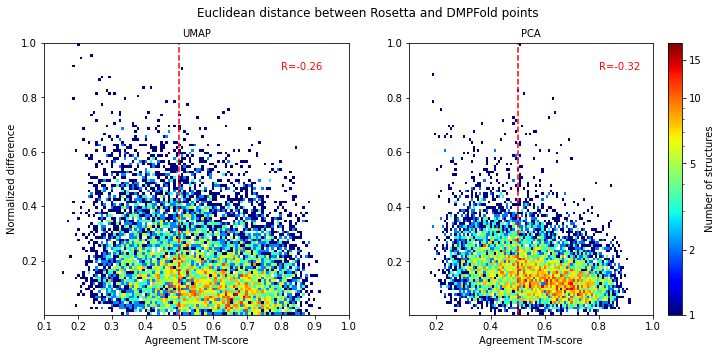

In [16]:
fig = plt.figure(figsize=(12, 5))
labels = ['UMAP', 'PCA']
cols = ['diff UMAP', 'diff PCA']
for i in range(len(cols)):
    ax = plt.subplot(1, 2, i+1)
    x, y = compared['Agreement TM-score'], compared[cols[i]]
    plt.hist2d(x, y, (100, 100), norm=mpl.colors.LogNorm(), cmap=plt.cm.jet)
    corr = pearsonr(x, y)
    plt.text(0.8, 0.9, f'R={corr[0]:.2f}', color='r')
    plt.axvline(x=0.5, color='r', linestyle='--')
    if i == 1:
        cbar=plt.colorbar()
        cbar.ax.set_ylabel('Number of structures')
        cbar.set_ticks([1, 2, 5, 10, 15])
        cbar.set_ticklabels([1, 2, 5, 10, 15])
    if i == 0:
        plt.ylabel('Normalized difference', fontsize=10)
    plt.xlabel('Agreement TM-score', fontsize=10)
    plt.title(labels[i], fontsize=10)
    plt.xlim([0.1, 1])
plt.suptitle('Euclidean distance between Rosetta and DMPFold points', fontsize=12)
plt.show()